In [1]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)

import pandas as pd
pd.options.display.max_columns = 100

from matplotlib import pyplot as plt
import numpy as np

import seaborn as sns
sns.set(rc={'figure.figsize':(12,9)})
import pylab as plot
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss,accuracy_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [2]:
from xgboost import XGBClassifier
import xgboost as xgb

In [3]:
#for scaling
from sklearn.preprocessing import StandardScaler

Importing training dataset

In [4]:
data = pd.read_csv('./train.csv')

In [5]:
print(data.shape)

(867873, 10)


In [6]:
data.columns

Index(['Dates', 'Category', 'Descript', 'DayOfWeek', 'PdDistrict',
       'Resolution', 'Address', 'X', 'Y', 'Id'],
      dtype='object')

Splitting the "Dates" into date and time

In [32]:
df=data
datetime=df.Dates.str.split(pat=" ",expand=True)
datetime.columns=['Date','Time']
#datetime

In [33]:
Date=datetime.Date.str.split(pat="-",expand=True)
Date.columns=['Year','Month','Day']

Time=datetime.Time.str.split(pat=":",expand=True)
Time.columns=['Hour','Minute','Second']

Dropping the column of "Dates" and appending the dataframe "datetime"

In [34]:
df=pd.concat([df,Date,Time],axis=1)
#df

In [35]:
df=df.drop(labels=['Dates'],axis=1)

# #Encoding

In [36]:
df.columns

Index(['Category', 'Descript', 'DayOfWeek', 'PdDistrict', 'Resolution',
       'Address', 'X', 'Y', 'Id', 'Year', 'Month', 'Day', 'Hour', 'Minute',
       'Second'],
      dtype='object')

LabelEncoding of "DayOfWeek" and "PdDistrict"

In [37]:
le = preprocessing.LabelEncoder()

In [38]:
#y=pd.get_dummies(df.Category,columns=['Category'],prefix=" ",prefix_sep=" ",drop_first=True,)

le_res=le.fit_transform(df['Category'])
y=pd.DataFrame(le_res)
y.columns=['Category']
#y

# Rotation 45 degree

In [39]:
df['Y']=df['Y'].apply(lambda x : x if 37.82 > x else 37.82)
df['X']=df['X'].apply(lambda x : x if -122.3 > x else 122.3)

In [40]:
df["rot45_X"]=0.707 * df["Y"] + 0.707 * df["X"]
df["rot45_Y"]=0.707 * df["Y"] - 0.707 * df["X"]

In [41]:
df["radial45"]=np.sqrt(np.power(df['rot45_X'],2) + np.power(df['rot45_Y'],2))

# Rotation 30 degree

In [42]:
df["rot30_X"]=(1.732/2) * df["Y"] + 0.5 * df["X"]
df["rot30_Y"]=(1.732/2) * df["Y"] - 0.5 * df["X"]


In [43]:
df["radial30"]=np.sqrt(np.power(df['rot30_X'],2) + np.power(df['rot30_Y'],2))

# Rotation 60 degress

In [44]:
df["rot60_X"]=(0.5) * df["Y"] + (1.732/2) * df["X"]
df["rot60_Y"]=0.5 * df["Y"] - (1.732/2) * df["X"]


In [45]:
df["radial60"]=np.sqrt(np.power(df['rot60_X'],2) + np.power(df['rot60_Y'],2))

# Hours clubing

In [46]:
df['Hour']=df['Hour'].apply(lambda x:int(x))
#df['Hour']=df['Hour'].apply(lambda x : 'EARLY_Morning' if (x >= 1) and (x <=5) else ('MORNING' if x >= 6 and x <=11 else ('DAY' if x>=12 and x<=18 else 'Night')))
df['Hour']=df['Hour'].apply(lambda x : 'EARLY_MORNING' if x in (1,2,3,4,5) else ('MORNING' if x in (6,7,8,9,10,11) else ('DAY' if x in (12,13,14,15,16,17,18) else 'NIGHT')))

# Month Clubing

In [47]:
df['Month']=df['Month'].apply(lambda x:int(x))
df['Month']=df['Month'].apply(lambda x : 'MonthLow' if x== 12 else ('MonthMed' if x in (2,6,7,8,9,11) else 'MonthHigh'))

# Minutes Clubing 

In [48]:
df['Minute']=df['Minute'].apply(lambda x:int(x))
df['Minute']=df['Minute'].apply(lambda x : 'low' if x <31 else 'high')

In [49]:
df.head()

Category                             Descript  DayOfWeek  \
0  SEX OFFENSES FORCIBLE          FORCIBLE RAPE, BODILY FORCE     Friday   
1            LIQUOR LAWS     CONSUMING ALCOHOL IN PUBLIC VIEW   Thursday   
2                  FRAUD         CREDIT CARD, THEFT BY USE OF  Wednesday   
3                ROBBERY  ROBBERY OF A CHAIN STORE WITH A GUN   Thursday   
4         OTHER OFFENSES                  PROBATION VIOLATION     Sunday   

  PdDistrict                              Resolution  \
0    MISSION                                    NONE   
1   SOUTHERN                          ARREST, BOOKED   
2   SOUTHERN                                    NONE   
3    BAYVIEW  DISTRICT ATTORNEY REFUSES TO PROSECUTE   
4   SOUTHERN                          ARREST, BOOKED   

                      Address           X          Y      Id  Year     Month  \
0    2100 Block of MISSION ST -122.419331  37.762264  141546  2013  MonthMed   
1     1000 Block of MARKET ST -122.411340  37.781271  794152  2004  MonthMed   
2      800 Block of BRYANT ST -122.403405  37.775421  531205  2007  MonthMed   
3  2400 Block of SAN BRUNO AV -122.404715  37.730161  523137  2007  MonthLow   
4       4TH ST / STEVENSON ST -122.405239  37.785265  200968  2012  MonthMed   

  Day           Hour Minute Second    rot45_X     rot45_Y    radial45  \
0  28            DAY   high     00 -59.852546  113.248388  128.091860   
1  19  EARLY_MORNING   high     00 -59.833459  113.256175  128.089828   
2  14          NIGHT    low     00 -59.831985  113.246430  128.080522   
3  27            DAY    low     00 -59.864910  113.215357  128.068437   
4  09            DAY    low     00 -59.826321  113.254686  128.085177   

     rot30_X    rot30_Y   radial30    rot60_X     rot60_Y    radial60  
0 -28.507545  93.911786  98.143282 -87.134009  124.896273  152.287276  
1 -28.487089  93.924250  98.149269 -87.117585  124.898855  152.279998  
2 -28.488188  93.915217  98.140944 -87.113638  124.889059  152.269705  
3 -28.528038  93.876677  98.115643 -87.137403  124.867564  152.265674  
4 -28.480580  93.924659  98.147771 -87.110304  124.895569  152.273137

# Address splitting

In [50]:
address=pd.DataFrame(df['Address'],columns=['Address'])
address=address.Address.str.split(pat=" /",expand=True )

address.columns=['Address','Intr2']

address=address.Address.str.split(pat=" /",expand=True )
address.columns=['Address']

In [51]:
address.head()

Address
0    2100 Block of MISSION ST
1     1000 Block of MARKET ST
2      800 Block of BRYANT ST
3  2400 Block of SAN BRUNO AV
4                      4TH ST

In [52]:
string=address.iloc[:,0]
string=string.str.strip()

In [53]:
address_fram=string.to_frame()
temp=address_fram['Address'].astype(str).str[-2:]

In [54]:
temp.unique()

array(['ST', 'AV', 'LN', 'DR', 'BL', 'HY', 'CT', 'RD', 'PL', 'PZ', '80',
       'TR', 'WY', 'AL', 'AY', 'ER', 'MS', 'CR', 'TI', 'WK', 'AR', 'EX',
       'NO', 'RK', 'RW'], dtype=object)

In [55]:
address=temp.to_frame()

("ST","AV","LN","DR","BL","HY","CT","RD","PL","PZ","TR","AL","CR","WK","EX","RW")

In [56]:
address['Address']=address['Address'].apply(lambda x :( x if x in ("ST","AV","LN","DR","BL","HY","CT","RD","PL","PZ","TR","AL","CR","WK","EX","RW") else (("I-80" if x in ("80") else ("HWY" if x in ("WY") else ("WAY" if x in ("AY") else ("TER" if x in ("ER") else ("ALMS" if x in ("MS") else ("MAR" if x in ("AR") else ("PARK" if x in ("RK") else ("STWY" if x in ("WY") else ("VIA" if x in ("NO") else ("BLOCK")))))))))))))

In [57]:
#address.to_csv("Address.csv", float_format = '%.5F')

In [58]:
df=df.drop(labels=['Address'],axis=1)

Concatenating "df" and "address"

In [59]:
df=pd.concat([address,df],axis=1)

In [61]:
Id=df['Id']
df=df.drop(['Descript','Category','Resolution','Id','Second'],axis=1)

In [62]:
df.head()

Address  DayOfWeek PdDistrict           X          Y  Year     Month Day  \
0      ST     Friday    MISSION -122.419331  37.762264  2013  MonthMed  28   
1      ST   Thursday   SOUTHERN -122.411340  37.781271  2004  MonthMed  19   
2      ST  Wednesday   SOUTHERN -122.403405  37.775421  2007  MonthMed  14   
3      AV   Thursday    BAYVIEW -122.404715  37.730161  2007  MonthLow  27   
4      ST     Sunday   SOUTHERN -122.405239  37.785265  2012  MonthMed  09   

            Hour Minute    rot45_X     rot45_Y    radial45    rot30_X  \
0            DAY   high -59.852546  113.248388  128.091860 -28.507545   
1  EARLY_MORNING   high -59.833459  113.256175  128.089828 -28.487089   
2          NIGHT    low -59.831985  113.246430  128.080522 -28.488188   
3            DAY    low -59.864910  113.215357  128.068437 -28.528038   
4            DAY    low -59.826321  113.254686  128.085177 -28.480580   

     rot30_Y   radial30    rot60_X     rot60_Y    radial60  
0  93.911786  98.143282 -87.134009  124.896273  152.287276  
1  93.924250  98.149269 -87.117585  124.898855  152.279998  
2  93.915217  98.140944 -87.113638  124.889059  152.269705  
3  93.876677  98.115643 -87.137403  124.867564  152.265674  
4  93.924659  98.147771 -87.110304  124.895569  152.273137

Label Encoded Columns :PdDistrict ,Address ,X ,Y

In [63]:
data['PdDistrict'].unique()

array(['MISSION', 'SOUTHERN', 'BAYVIEW', 'CENTRAL', 'INGLESIDE',
       'NORTHERN', 'RICHMOND', 'TARAVAL', 'TENDERLOIN', 'PARK'],
      dtype=object)

# Label Encoding

In [31]:
le = preprocessing.LabelEncoder()

# One Hot Encoding

In [64]:
df=pd.get_dummies(df,columns=['Address', 'DayOfWeek', 'PdDistrict','Year','Month','Day','Hour','Minute'],drop_first=True)

In [66]:
df.shape

(867873, 98)

# Feature Scaling

In [29]:

scaler=StandardScaler(copy=True, with_mean=True, with_std=True)
lt_res=scaler.fit_transform([df['X']])
Longitude=pd.DataFrame(lt_res,)



36 Crime Category are there 

# Applying different Models

In [67]:
#Independent Column
X=df
X.shape

(867873, 98)

In [68]:
#Dependent column
y.shape

(867873, 1)

In [69]:
#splitting the dataset into the training set and test set
#from sklearn import model_selection as ms

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.33,random_state=0)

In [32]:
"""from sklearn.preprocessing import StandardScaler
sc_X=StandardScaler()
X_train=sc_X.fit_tranform(X_train)
X_test=sc_X.transform(X_test)"""

'from sklearn.preprocessing import StandardScaler\nsc_X=StandardScaler()\nX_train=sc_X.fit_tranform(X_train)\nX_test=sc_X.transform(X_test)'

# Logistic Regression

Feature scaling


In [98]:
from sklearn.linear_model import LogisticRegression
#weight={Address:3,District:3,X:1,Day:2}
#weight={LARCENY/THEFT:35}
classifier = LogisticRegression(penalty='l2',random_state = 0,class_weight='balanced',multi_class='multinomial', solver='lbfgs',n_jobs=-1)
classifier.fit(X_train,y_train)
# Applying k-Fold Cross Validation
"""from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier, X=df , y=y , cv = 10,n_jobs=-1)
print("Logistic Regression:\n Accuracy:", accuracies.mean(), "+/-", accuracies.std(),"\n")
"""

'from sklearn.model_selection import cross_val_score\naccuracies = cross_val_score(estimator = classifier, X=df , y=y , cv = 10,n_jobs=-1)\nprint("Logistic Regression:\n Accuracy:", accuracies.mean(), "+/-", accuracies.std(),"\n")\n'

In [99]:
#predicting the Test set result
y_pred=classifier.predict_proba(X_test)

In [100]:
# y_test=np.array(y_pred)
# y_pred

In [101]:
type(y_test)

pandas.core.frame.DataFrame

In [102]:
X_train.columns


Index(['Hour', 'Day', 'Month', 'Year', 'Address', 'District', 'DayOfWeek', 'X',
       'Y'],
      dtype='object')

In [103]:
# def logloss(y_true, y_pred, eps=1e-15):
#     y_pred = np.clip(y_pred, eps, 1 - eps)
#     return -(y_true * np.log(y_pred)).sum(axis=1).mean()
ll = log_loss(y_test,y_pred)
ll

3.5351830522637937

# XGBoost Model

In [70]:
X.head()

X          Y    rot45_X     rot45_Y    radial45    rot30_X  \
0 -122.419331  37.762264 -59.852546  113.248388  128.091860 -28.507545   
1 -122.411340  37.781271 -59.833459  113.256175  128.089828 -28.487089   
2 -122.403405  37.775421 -59.831985  113.246430  128.080522 -28.488188   
3 -122.404715  37.730161 -59.864910  113.215357  128.068437 -28.528038   
4 -122.405239  37.785265 -59.826321  113.254686  128.085177 -28.480580   

     rot30_Y   radial30    rot60_X     rot60_Y    radial60  Address_ALMS  \
0  93.911786  98.143282 -87.134009  124.896273  152.287276             0   
1  93.924250  98.149269 -87.117585  124.898855  152.279998             0   
2  93.915217  98.140944 -87.113638  124.889059  152.269705             0   
3  93.876677  98.115643 -87.137403  124.867564  152.265674             0   
4  93.924659  98.147771 -87.110304  124.895569  152.273137             0   

   Address_AV  Address_BL  Address_BLOCK  Address_CR  Address_CT  Address_DR  \
0           0           0              0           0           0           0   
1           0           0              0           0           0           0   
2           0           0              0           0           0           0   
3           1           0              0           0           0           0   
4           0           0              0           0           0           0   

   Address_EX  Address_HWY  Address_HY  Address_I-80  Address_LN  Address_MAR  \
0           0            0           0             0           0            0   
1           0            0           0             0           0            0   
2           0            0           0             0           0            0   
3           0            0           0             0           0            0   
4           0            0           0             0           0            0   

   Address_PARK  Address_PL  Address_PZ  Address_RD  Address_RW  Address_ST  \
0             0           0           0           0           0           1   
1             0           0           0           0           0           1   
2             0           0           0           0           0           1   
3             0           0           0           0           0           0   
4             0           0           0           0           0           1   

   Address_TER  Address_TR  Address_VIA  Address_WAY  Address_WK  \
0            0           0            0            0           0   
1            0           0            0            0           0   
2            0           0            0            0           0   
3            0           0            0            0           0   
4            0           0            0            0           0   

   DayOfWeek_Monday  DayOfWeek_Saturday  DayOfWeek_Sunday  DayOfWeek_Thursday  \
0                 0                   0                 0                   0   
1                 0                   0                 0                   1   
2                 0                   0                 0                   0   
3                 0                   0                 0                   1   
4                 0                   0                 1                   0   

   DayOfWeek_Tuesday  DayOfWeek_Wednesday  PdDistrict_CENTRAL  \
0                  0                    0                   0   
1                  0                    0                   0   
2                  0                    1                   0   
3                  0                    0                   0   
4                  0                    0                   0   

   PdDistrict_INGLESIDE  PdDistrict_MISSION  PdDistrict_NORTHERN  \
0                     0                   1                    0   
1                     0                   0                    0   
2                     0                   0                    0   
3                     0                   0                    0   
4                     0                 

In [ ]:
model = xgb.XGBClassifier(objective='multi:softprob')
model.fit(X_train, y_train)

C:\anaconda\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\anaconda\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [109]:
y_pred=model.predict_proba(X_test)

In [110]:
print (log_loss(y_test,y_pred));

2.4825743596979577


Early Stopping in XGBoost

In [37]:
model = XGBClassifier(objective='multi:softprob')
eval_set = [(X_test, y_test)]
model.fit(X_train, y_train, early_stopping_rounds=10, eval_metric="mlogloss", eval_set=eval_set, verbose=True)

C:\anaconda\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\anaconda\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\anaconda\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[0]	validation_0-mlogloss:3.42722
Will train until validation_0-mlogloss hasn't improved in 10 rounds.
[1]	validation_0-mlogloss:3.31607
[2]	validation_0-mlogloss:3.22979
[3]	validation_0-mlogloss:3.15756
[4]	validation_0-mlogloss:3.0969
[5]	validation_0-mlogloss:3.04489
[6]	validation_0-mlogloss:2.99891
[7]	validation_0-mlogloss:2.9586
[8]	validation_0-mlogloss:2.92274
[9]	validation_0-mlogloss:2.89069
[10]	validation_0-mlogloss:2.86159
[11]	validation_0-mlogloss:2.83499
[12]	validation_0-mlogloss:2.811
[13]	validation_0-mlogloss:2.78906
[14]	validation_0-mlogloss:2.76912
[15]	validation_0-mlogloss:2.75094
[16]	validation_0-mlogloss:2.73411
[17]	validation_0-mlogloss:2.71827
[18]	validation_0-mlogloss:2.70373
[19]	validation_0-mlogloss:2.69066
[20]	validation_0-mlogloss:2.67818
[21]	validation_0-mlogloss:2.66666
[22]	validation_0-mlogloss:2.65626
[23]	validation_0-mlogloss:2.64634
[24]	validation_0-mlogloss:2.63736
[25]	validation_0-mlogloss:2.62887
[26]	validation_0-mlogloss:2.621
[2

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

PLot of Important Feature

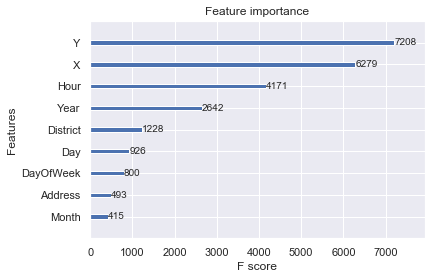

In [41]:
# plot feature importance
xgb.plot_importance(model)


# XGBoost Tuning Learning Rate

In [ ]:
learning_rate = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]
param_grid = dict(learning_rate=learning_rate)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
grid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X, Y)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))

# KNN  

In [39]:
#libraries
from sklearn.neighbors import KNeighborsClassifier

In [64]:
neigh = KNeighborsClassifier(n_neighbors =36,weights='distance',algorithm='ball_tree',n_jobs=-1,p=1, metric = 'minkowski',leaf_size=60)
neigh.fit(X_train,y_train)


C:\anaconda\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


KNeighborsClassifier(algorithm='ball_tree', leaf_size=60, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=36, p=1,
           weights='distance')

In [65]:
y_pred=neigh.predict_proba(X_test)

In [66]:
print (log_loss(y_test,y_pred));

11.481771132230303


ROC curve

In [63]:
"""from sklearn import metrics as ms
ms.roc_curve(y_test,y_pred)"""


'from sklearn import metrics as ms\nms.roc_curve(y_test,y_pred)'

# Random Forest

In [46]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
#max_depth=9
clf = RandomForestClassifier(n_estimators =20,criterion = 'entropy',random_state = 0)
clf.fit(X_train,y_train)

C:\anaconda\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


In [85]:
y_pred=clf.predict_proba(X_test)

In [86]:
print (log_loss(y_test,y_pred));

2.476801241944063


# Naive Bayes

In [36]:
from sklearn.naive_bayes import GaussianNB

In [2]:
nv = GaussianNB(priors=None, var_smoothing=1e-01)
nv.fit(X_train,y_train)

NameError: name 'X_train' is not defined

In [59]:
y_pred=nv.predict_proba(X_test)

In [60]:
print (log_loss(y_test,y_pred));

2.643182143409891


In [62]:
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = nv, X=X_train , y=y_train , cv = 10)

C:\anaconda\lib\site-packages\sklearn\utils\validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\anaconda\lib\site-packages\sklearn\utils\validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\anaconda\lib\site-packages\sklearn\utils\validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\anaconda\lib\site-packages\sklearn\utils\validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, war

In [63]:
accuracies

array([0.20506492, 0.20378843, 0.20328187, 0.20405577, 0.20503029,
       0.20349306, 0.20604504, 0.20465246, 0.20385249, 0.20492937])

# Decision Tree

In [33]:
from sklearn import tree

In [34]:
"""model = tree.DecisionTreeClassifier(random_state=1)
model.fit(X_train, y_train)
model.predict_proba(X_test, y_test)"""

ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [ ]:
#print (log_loss(y_test,y_pred));

# Bagging Classifier

In [ ]:
#model = BaggingClassifier(tree.DecisionTreeClassifier(random_state=1))
#model.fit(x_train, y_train)
#model.score(x_test,y_test)

# "Esemble of Models"


# AdaBoost

In [ ]:
#nv = GaussianNB(priors=None, var_smoothing=1e-01)
cfl = XGBClassifier(objective='multi:softprob')
ada = AdaBoostClassifier(base_estimator=cfl,random_state=0)
ada.fit(X_train, y_train)


In [44]:
y_pred=ada.predict_proba(X_test)

In [45]:
print (log_loss(y_test,y_pred));

3.5337949491988154


# Gradient Boosting


In [35]:
clf=GradientBoostingClassifier(n_estimators=20,learning_rate=0.01,random_state=0)
clf.fit(X_train, y_train)


C:\anaconda\lib\site-packages\sklearn\utils\validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=20,
              n_iter_no_change=None, presort='auto', random_state=0,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [ ]:
y_pred=clf.predict_proba(x_test,y_test)

In [ ]:
print (log_loss(y_test,y_pred));

# esembling Logistic and Random Forest

In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
classifier = LogisticRegression(penalty='l2',random_state = 0,class_weight='balanced',multi_class='multinomial', solver='lbfgs',n_jobs=-1)
clf = RandomForestClassifier(n_estimators =20,criterion = 'entropy',random_state = 0)
model = VotingClassifier(estimators=[('rf',clf), ('lr',classifier)], voting='soft')
model.fit(X_train,y_train)
model.score(X_test,y_test)

C:\anaconda\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\anaconda\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
